In [73]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

In [65]:
class MLP(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()
        self.layyers = nn.ModuleList()
        for i in range(len(layer_dims) - 1):
            self.layyers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layyers[:-1]:
            x = self.activation(layer(x))
        x = self.layyers[-1](x)
        return x
    
class PINN_Burgers(nn.Module):
    def __init__(self, layer_dims, true_nu=None):
        super().__init__()
        self.network = MLP(layer_dims)
        
        # 将 nu 定义为一个可学习的参数
        # 我们用一个猜测值进行初始化，例如 0.1
        # 如果提供了 true_nu，则使用它（用于调试/测试正向问题）
        initial_nu = 0.1 if true_nu is None else true_nu
        self.nu = nn.Parameter(torch.tensor([initial_nu], dtype=torch.float32, requires_grad=True))
    
    def forward(self, x, t):
        # 拼接 x 和 t 以创建网络输入
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)
    
    def compute_pde_residual(self, x, t):
        # 为输入设置 requires_grad=True 以计算导数
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        u = self.forward(x, t)
        
        # 使用自动微分计算导数
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # 伯格斯方程残差
        residual = u_t + u * u_x - self.nu * u_xx
        return residual


In [66]:
class Standard_PINN(nn.Module):
    def __init__(self, layer_dims, nu):
        super().__init__()
        self.network = MLP(layer_dims)
        # nu 现在是已知的、固定的值，不再是可学习参数
        self.nu = nu

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)

    def compute_pde_residual(self, x, t):
        # ... (这部分和之前iPINN的完全一样) ...
        u = self.forward(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        residual = u_t + u * u_x - self.nu * u_xx
        return residual

In [67]:
# 加载数据
data = np.load('burgers_shock_solution.npz') # 假设 nu=0.04 的数据
t, x, u_sol = data['t'], data['x'], data['u']

# 将 (t, x) 坐标对网格化，并与 u 对应
T, X = np.meshgrid(t, x, indexing='ij')
x_flat = X.flatten()
t_flat = T.flatten()
u_flat = u_sol.flatten()

# --- 初始条件 (IC) ---
# 讲解：IC 定义了系统在 t=0 时刻的状态。我们从全部数据中筛选出所有 t=0 的点。
# 网络在训练时，必须在这些点上输出正确的 u 值。
t_ic_mask = (t_flat == t[0])
x_ic_np = x_flat[t_ic_mask].reshape(-1, 1)
t_ic_np = t_flat[t_ic_mask].reshape(-1, 1)
u_ic_np = u_flat[t_ic_mask].reshape(-1, 1)

# --- 边界条件 (BC) ---
# 讲解：BC 定义了系统在空间边界 (x_min, x_max) 上的行为。我们筛选出所有在边界上的点。
# 同样的，网络必须在这些点上输出正确的 u 值。
x_bc_mask = (x_flat == x[0]) | (x_flat == x[-1])
x_bc_np = x_flat[x_bc_mask].reshape(-1, 1)
t_bc_np = t_flat[x_bc_mask].reshape(-1, 1)
u_bc_np = u_flat[x_bc_mask].reshape(-1, 1)

In [69]:
# --- 物理点 (Collocation Points) ---
# 讲解：这是标准 PINN 的精髓。我们在整个时空域内随机撒点。
# 在这些点上，我们没有任何 u 的真值信息。我们唯一知道的是，在这些点上，
# 解必须满足伯格斯方程。因此，我们通过最小化这些点上的 PDE 残差来 "监督" 网络的行为。
# 这里的 `N_f` 数量远大于 IC 和 BC 点的数量，体现了物理方程在整个求解过程中的主导地位。
N_f = 20000
t_min, t_max = t.min(), t.max()
x_min, x_max = x.min(), x.max()
# 使用 Latin Hypercube Sampling (LHS) 可以让采样更均匀，但随机采样也足够
x_physics_np = np.random.uniform(x_min, x_max, N_f).reshape(-1, 1)
t_physics_np = np.random.uniform(t_min, t_max, N_f).reshape(-1, 1)

# --- 数据转换 (Numpy to Tensor) ---
x_ic = torch.tensor(x_ic_np, dtype=torch.float32).to(device)
t_ic = torch.tensor(t_ic_np, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_np, dtype=torch.float32).to(device)

x_bc = torch.tensor(x_bc_np, dtype=torch.float32).to(device)
t_bc = torch.tensor(t_bc_np, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc_np, dtype=torch.float32).to(device)

x_physics = torch.tensor(x_physics_np, dtype=torch.float32, requires_grad=True).to(device)
t_physics = torch.tensor(t_physics_np, dtype=torch.float32, requires_grad=True).to(device)

# --- 3. 模型、优化器等设置 ---
# 讲解：我们明确地告诉模型，物理方程中的粘性系数 nu 是 0.04。
# 这是一个已知条件，是 "正问题" 的一部分。
known_nu = 0.07 / np.pi # 根据原始伯格斯方程定义 nu/pi
layer_dims = [2, 32, 32, 32, 32, 1]
model = Standard_PINN(layer_dims=layer_dims, nu=known_nu).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
# --- 4. 训练循环 ---
# 讲解：这是标准 PINN 的训练核心。每一步的损失由三部分构成：
# 1. loss_ic: 衡量模型在初始条件上的预测与真实值的差距。
# 2. loss_bc: 衡量模型在边界条件上的预测与真实值的差距。
# 3. loss_physics: 衡量模型在物理点上的 PDE 残差。我们希望残差趋近于 0，
#    所以将 `residual` 与一个全零的张量 `torch.zeros_like(residual)` 计算 MSE。
# total_loss: 将这三部分损失相加（也可以加权相加），形成总的优化目标。
# 通过最小化 total_loss，我们迫使神经网络同时满足边界/初始条件和物理定律。
## 本质上是通过初始条件，边界条件，物理定律来约束模型的学习过程，使三者的总损失最小
epochs = 15000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 计算 IC 损失
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = loss_fn(u_pred_ic, u_ic)
    
    # 计算 BC 损失
    u_pred_bc = model(x_bc, t_bc)
    loss_bc = loss_fn(u_pred_bc, u_bc)
    
    # 计算物理损失
    residual = model.compute_pde_residual(x_physics, t_physics)
    loss_physics = loss_fn(residual, torch.zeros_like(residual))
    
    # 总损失
    total_loss = loss_ic + loss_bc + loss_physics
    
    # 反向传播和优化
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4e}, '
                f'IC Loss: {loss_ic.item():.4e}, BC Loss: {loss_bc.item():.4e}, '
                f'Physics Loss: {loss_physics.item():.4e}')

Epoch [1000/15000], Total Loss: 3.0262e-02, IC Loss: 1.3301e-02, BC Loss: 8.8084e-04, Physics Loss: 1.6080e-02
Epoch [2000/15000], Total Loss: 7.8507e-03, IC Loss: 2.8884e-03, BC Loss: 3.2306e-04, Physics Loss: 4.6392e-03
Epoch [3000/15000], Total Loss: 2.1937e-03, IC Loss: 4.8659e-04, BC Loss: 1.8717e-04, Physics Loss: 1.5199e-03
Epoch [4000/15000], Total Loss: 4.8334e-03, IC Loss: 8.3834e-04, BC Loss: 7.7802e-04, Physics Loss: 3.2170e-03
Epoch [5000/15000], Total Loss: 8.9802e-04, IC Loss: 1.7702e-04, BC Loss: 5.5351e-05, Physics Loss: 6.6565e-04
Epoch [6000/15000], Total Loss: 8.2695e-04, IC Loss: 2.5881e-04, BC Loss: 2.0744e-05, Physics Loss: 5.4740e-04
Epoch [7000/15000], Total Loss: 5.5811e-04, IC Loss: 1.1580e-04, BC Loss: 2.8914e-05, Physics Loss: 4.1340e-04
Epoch [8000/15000], Total Loss: 4.4895e-04, IC Loss: 9.8580e-05, BC Loss: 2.2243e-05, Physics Loss: 3.2813e-04
Epoch [9000/15000], Total Loss: 4.8507e-04, IC Loss: 9.1996e-05, BC Loss: 4.4608e-05, Physics Loss: 3.4846e-04
E

In [71]:
# --- 5. 模型评估 ---
# 讲解：在可视化之前，我们先对模型在整个时空域上的性能进行定量评估。
# R2 分数 (决定系数) 是一个很好的指标，它衡量了模型预测值与真实值之间的拟合优度。
# R2=1 表示完美拟合，R2=0 表示模型等同于用均值来预测，R2<0 表示模型比均值预测还差。
print("\n--- Evaluating Model Performance ---")
model.eval()

# 准备整个时空域的测试数据
x_all = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32).to(device)
t_all = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32).to(device)
u_true_flat = u_sol.flatten()

with torch.no_grad():
    u_pred_flat = model(x_all, t_all).cpu().numpy().flatten()

# 计算均方误差 (MSE)
mse = np.mean((u_true_flat - u_pred_flat)**2)
print(f"Mean Squared Error (MSE) on the entire domain: {mse:.4e}")

# 计算 R2 分数
ss_total = np.sum((u_true_flat - np.mean(u_true_flat))**2)
ss_residual = np.sum((u_true_flat - u_pred_flat)**2)
r2 = 1 - (ss_residual / ss_total)
print(f"R-squared (R2) score on the entire domain: {r2:.4f}")


--- Evaluating Model Performance ---
Mean Squared Error (MSE) on the entire domain: 2.5377e-02
R-squared (R2) score on the entire domain: 0.9256


In [79]:
# 保存标准 PINN 模型
PATH = r"D:\A-Code\GitHubCode\Pytorch-PINN-Learning\model\stage4_standard_pinn_model.pth"
torch.save(model.state_dict(), PATH)


Generating 1D comparison plot...


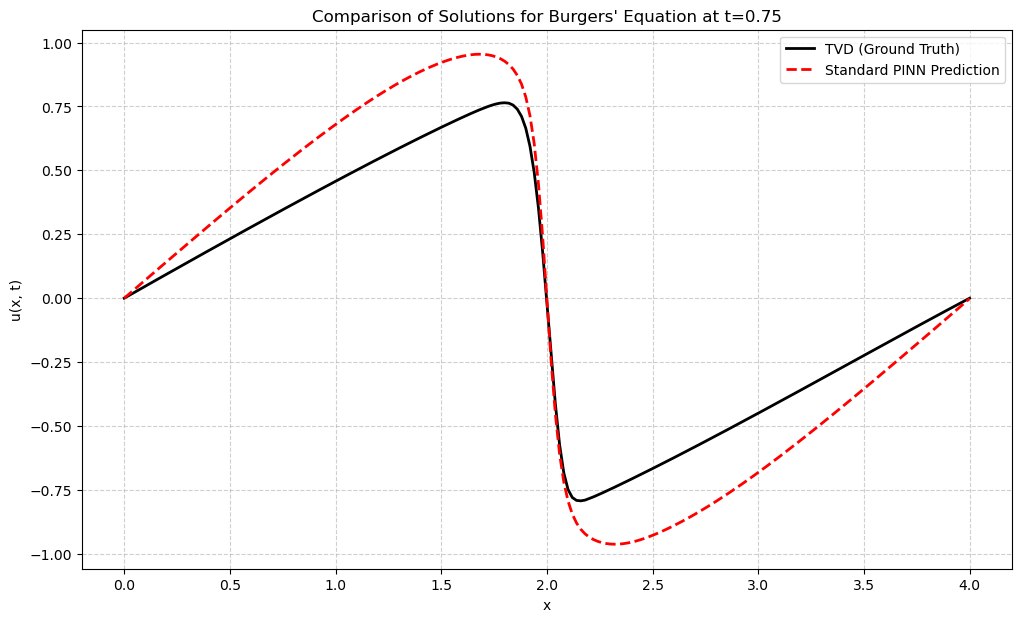

In [74]:
# --- 6. 最终对比与可视化 (1D) ---
print("\nGenerating 1D comparison plot...")

t_test_val = 0.75
t_test_idx = np.argmin(np.abs(t - t_test_val))
x_test_np = x.reshape(-1, 1)
t_test_np = np.full_like(x_test_np, t[t_test_idx])

x_test = torch.tensor(x_test_np, dtype=torch.float32).to(device)
t_test = torch.tensor(t_test_np, dtype=torch.float32).to(device)

u_tvd = u_sol[t_test_idx, :]

ipinn_model_path = 'stage3_ipinn_model.pth'
if os.path.exists(ipinn_model_path):
    ipinn_model = Inverse_PINN(layer_dims=layer_dims).to(device)
    ipinn_model.load_state_dict(torch.load(ipinn_model_path, map_location=device))
    ipinn_model.eval()
    with torch.no_grad():
        u_ipinn_pred = ipinn_model(x_test, t_test).cpu().numpy().flatten()
else:
    print(f"Warning: iPINN model not found at {ipinn_model_path}. Skipping iPINN comparison.")
    u_ipinn_pred = np.full_like(u_tvd, np.nan)

with torch.no_grad():
    u_pinn_pred = model(x_test, t_test).cpu().numpy().flatten()

plt.figure(figsize=(12, 7))
plt.plot(x, u_tvd, 'k-', label='TVD (Ground Truth)', linewidth=2)
plt.plot(x, u_pinn_pred, 'r--', label='Standard PINN Prediction', linewidth=2)
if not np.isnan(u_ipinn_pred).any():
    plt.plot(x, u_ipinn_pred, 'b:', label='iPINN Reconstruction', linewidth=2)

plt.title(f'Comparison of Solutions for Burgers\' Equation at t={t[t_test_idx]:.2f}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Generating 2D heatmap visualization...


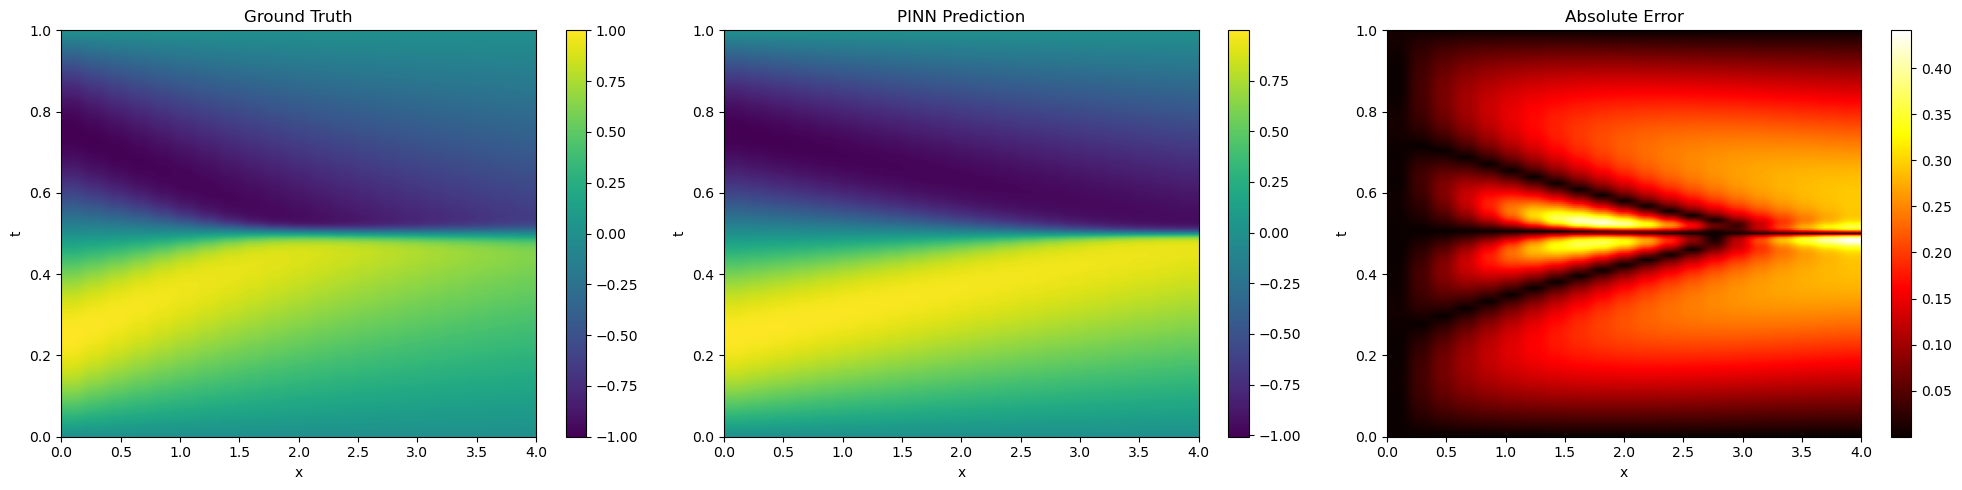

In [75]:
# --- 7. 2D 可视化：时空热图 ---
# 讲解：这部分代码将模型在整个时空域的预测结果、真实解以及它们之间的误差绘制成热图。
# 这能让我们对模型的整体性能有一个非常直观的认识。
print("\nGenerating 2D heatmap visualization...")

# 将扁平化的预测结果重新塑形为网格状
u_pred_grid = u_pred_flat.reshape(u_sol.shape)

# 计算绝对误差
error = np.abs(u_sol - u_pred_grid)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 绘图范围
extent = [x_min, x_max, t_min, t_max]

# 1. 绘制真实解
im1 = axes[0].imshow(u_sol.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# 2. 绘制 PINN 预测解
im2 = axes[1].imshow(u_pred_grid.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title('PINN Prediction')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# 3. 绘制绝对误差
im3 = axes[2].imshow(error.T, extent=extent, origin='lower', aspect='auto', cmap='hot')
axes[2].set_title('Absolute Error')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

